# Weather prediction example

This notebook shows a simple way to predict time series data using a PredictLite neural network

(c) Mikko Kursula 2022. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2017, 1, 1)
end_dt = datetime(2022, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2017-01-01 00:00:00,0.1,-3.1,79.0,NaN,NaN,230.0,13.0,NaN,996.5,NaN,NaN
2017-01-01 01:00:00,-0.5,-2.9,84.0,NaN,NaN,230.0,14.8,NaN,996.4,NaN,NaN
2017-01-01 02:00:00,0.0,-2.2,85.0,NaN,NaN,220.0,9.4,NaN,996.6,NaN,NaN
2017-01-01 03:00:00,-2.2,-3.6,90.0,NaN,NaN,230.0,13.0,NaN,996.6,NaN,NaN
2017-01-01 04:00:00,-3.2,-4.2,93.0,NaN,NaN,240.0,11.2,NaN,996.8,NaN,NaN


### Setup and train PredictLite model 

In [3]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_length=72,
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
)

model.fit(dataset, train_sample_n=10000, test_sample_n=1000)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 2183.27968, test loss: 695.60757
epoch:   1, train loss: 354.86279, test loss: 212.96486
epoch:   2, train loss: 168.29827, test loss: 150.08507
epoch:   3, train loss: 140.96849, test loss: 132.61536
epoch:   4, train loss: 130.47745, test loss: 123.05086
epoch:   5, train loss: 123.45373, test loss: 116.20781
epoch:   6, train loss: 118.13039, test loss: 110.99668
epoch:   7, train loss: 113.56722, test loss: 106.64221
epoch:   8, train loss: 109.67808, test loss: 102.84532
epoch:   9, train loss: 106.23099, test loss: 99.37923
epoch:  10, train loss: 103.01400, test loss: 96.29381
epoch:  11, train loss: 100.27448, test loss: 93.58245
epoch:  12, train loss: 98.05176, test loss: 91.06620
epoch:  13, train loss: 95.54476, test loss: 88.78316
epoch:  14, train loss: 93.38546, test loss: 86.73745
epoch:  15, train loss: 91.62915, test loss: 84.84575
epoch:  16, train loss: 89.99390, test loss: 83.25818

In [4]:
model.model_summary()

Inputs:
	temp: 72
	rhum: 72
MLP:
	Linear(in_features=144, out_features=48, bias=True)
Outputs:
	temp: 24
	rhum: 24


### Make prediction

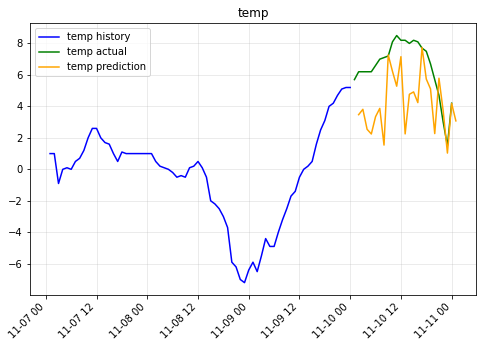

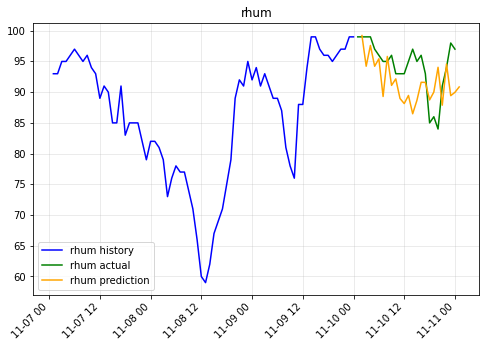

In [5]:
# Datetime for prediction start
prediction_time = datetime(2021, 11, 10, 1)

# Make prediction 
pred = model.predict(dataset, prediction_time)

# Plot data and prediction
pred_len = model.output_length
inp_len = model.input_length
for col in model.output_signals:
    
    ts_idx = dataset.index.get_loc(prediction_time, method='pad')
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - inp_len : ts_idx].values, 
        dataset.iloc[ts_idx - inp_len : ts_idx][col].values, 
        color='blue', 
        label='{} history'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + pred_len].values, 
        dataset.iloc[ts_idx : ts_idx + pred_len][col].values, 
        color='green',
        label='{} actual'.format(col)
    )
    plt.plot(
        pred.index.values, 
        pred[col].values, 
        color='orange', 
        label='{} prediction'.format(col)
    )
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(col)
    plt.show()